# Plot figures

Fig. 1. 

e. Check RT distribution for ions and fragments.

Fig. 2. Dependency on intensity (percentiles)




In [5]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 


## Dataset Metadata
calculated from CSM project. 

In [9]:
# Input data 

tof_datasets = [x.rstrip() for x in open('selected_16_tof_datasets.txt').readlines()]
pos_tof_datasets = [x for x in tof_datasets if 'pos' in x]
neg_tof_datasets = [x for x in tof_datasets if 'neg' in x]

In [7]:
def get_datasets_stats(dataset):
    '''get feature number, good feature number and isopaired khipu number based on the given dataset name
    
    dataset: str. Dataset name. 
    
    return number of features, number of good features and number of isopaired khipus.
    '''
    def _is_good_feature(line, snr=5, shape=0.9, sep='\t'):
        ''' 
        id_number	mz	rtime	rtime_left_base	rtime_right_base	parent_masstrack_id	peak_area	cSelectivity	goodness_fitting	snr
        '''
        a = line.split(sep)
        _snr, _shape = float(a[9]), float(a[8])
        if _snr > snr and _shape > shape:
            return True
        else:
            return False
        
    def get_feature_of_max_intensity(featureList):
        '''
        To get feature of max intensity, and avoid errors by sorting.
        e.g. sorted(M0, reverse=True)[0][1] leas to `TypeError: '<' not supported between instances of 'dict' and 'dict'`
        Use np.argmax here, which is okay with ties.
        '''
        ints = [f['representative_intensity'] for f in featureList]
        idx = np.argmax(ints)
        return featureList[idx]
    
    def get_M0(MS1_pseudo_Spectra):
        '''returns M0 feature with highest representative_intensity.
        Without verifying which ion form.'''
        M0 = [f for f in MS1_pseudo_Spectra if f['isotope']=='M0']
        if M0:
            return get_feature_of_max_intensity(M0)
        else:
            return []
        
    def get_M1(MS1_pseudo_Spectra):
        '''returns M+1 feature with highest representative_intensity.
        Without verifying which ion form.'''
        M = [f for f in 
            MS1_pseudo_Spectra if f['isotope']=='13C/12C']
        if M:
            return get_feature_of_max_intensity(M)
        else:
            return []
        
    def get_isopairs_good_khipus(list_empCpds, natural_ratio_limit=0.5):
        '''
        returns 
        Two lists of khipus, isopair_empCpds_ids (IDs only), good_khipus (full dict), and number of isopair_mtracks.
        isopair_empCpds = with good natural 13C ratio, based on M1/M0, not checking adduct form.
        good_khipus = isopair_empCpds and M0 being a good feature.
        
        Some inline MS/MS expts cause split MS1 peaks. Thus isopair_mtracks are more indicative of the data coverage.
        
        Usage
        -----
        full_list_empCpds  = json.load(open(json_empcpd))
        isopair_empCpds, num_isopair_mtracks, good_khipus = get_isopairs_good_khipus(full_list_empCpds)

        Use filter_khipus if not considering is_good_peak.
        '''
        isopair_empCpds_ids, isopair_mtracks, good_khipus = [], [], []
        for epd in list_empCpds:
            # interim_id = v['interim_id']
            M0, M1 = get_M0(epd['MS1_pseudo_Spectra']), get_M1(epd['MS1_pseudo_Spectra'])
            if M0 and M1:
                if float(M1['representative_intensity'])/(1 + float(M0['representative_intensity'])) < natural_ratio_limit:
                    isopair_empCpds_ids.append( epd['interim_id'] )
                    # if epd["MS1_pseudo_Spectra"][0]['is_good_peak']: 
                    # if M0['is_good_peak']: # not assuming first feature
                    if float(M0['snr']) > 5 and float(M0['goodness_fitting']) > 0.9:
                        good_khipus.append( epd )
                        isopair_mtracks.append( M0['parent_masstrack_id'] )

        return isopair_empCpds_ids, len(set(isopair_mtracks)), good_khipus
    
    
    # features
    ff_lines = open(f'../input_data_tof/{dataset}/full_feature_table.tsv', 'r').readlines()
    num_features = len(ff_lines) - 1
    num_good_features = len([line for line in ff_lines[1:] if _is_good_feature(line)])
    
    # ecpds
    khipus_isopairs, _, _ = get_isopairs_good_khipus(
        json.load(open(f'../input_data_tof/{dataset}/ecpds.json', 'r')))
    
    return num_features, num_good_features, len(khipus_isopairs)
    

In [10]:
datastats = pd.DataFrame()
datastats['feature_table_id'] = tof_datasets
# 5s
datastats[['num_features', 'num_good_features', 'num_khipus_isopairs']] = pd.DataFrame(
    datastats['feature_table_id'].map(get_datasets_stats).tolist()
)
datastats.set_index('feature_table_id', inplace=True)
datastats.head(3)

,num_features,num_good_features,num_khipus_isopairs
feature_table_id,,,
ST001828_RPneg_NEG_ppm25_1031133743,84791,32155,4156
ST000046_HILICpos__ppm25_1031113822,4173,2245,388
ST000726_RPneg__ppm25_1031133359,22350,9822,1960


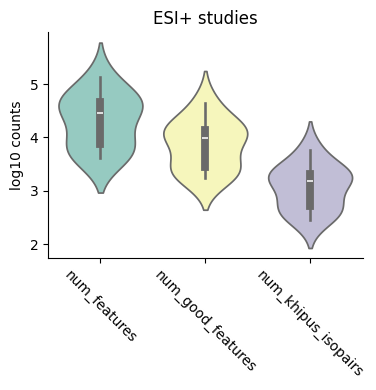

In [11]:
# Fig 1a
# data stats on studies, (#feature, #good features, #12/13C pairs)
_a = datastats.loc[pos_tof_datasets]
# Distribution of key numbers 
f, ax = plt.subplots(figsize=(4, 4))
sns.violinplot(data=np.log10(_a), palette="Set3")
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("log10 counts")
ax.set_title("ESI+ studies")
sns.despine() # left=True, bottom=True)
plt.tight_layout()
plt.savefig("figs/tof/Fig1a_studystats_pos_violionplots.pdf")

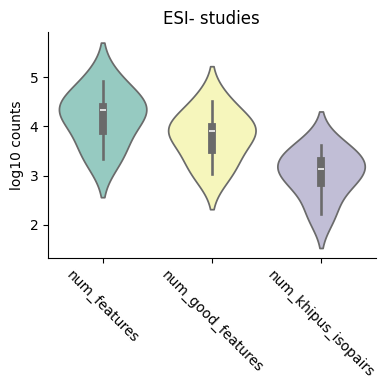

In [12]:
# Fig 1a neg data
# data stats on studies, (#feature, #good features, #12/13C pairs)
_a = datastats.loc[neg_tof_datasets]
# Distribution of key numbers 
f, ax = plt.subplots(figsize=(4, 4))
sns.violinplot(data=np.log10(_a), palette="Set3")
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("log10 counts")
ax.set_title("ESI- studies")
sns.despine() # left=True, bottom=True)
plt.tight_layout()
plt.savefig("figs/tof/Fig1a_studystats_neg_violionplots.pdf")

In [13]:
# Data structure, as recorded in previous step
'''
        {
            'study': f,
            'num_khipus': len(list_khipus),
            'num_features':  len(list_features),
            'mzdelta_explained_khipus': len(set(explained_khipu_ids)), 
            'mzdelta_explained_features': len(set(explained_feature_ids)),
            
            'freq_delta_values_used': delta_values_used,
            
            'have_precursors': len(have_precursors),
            'ms2_explained_features': len(matched2),
            
            'delta_values_ms2': delta_values_ms2,
        }
'''

pos_summary = json.load(open('isfExplained_result_tally_pos_tof_12272024.json'))
neg_summary = json.load(open('isfExplained_result_tally_neg_tof_12272024.json'))
len(pos_summary), len(neg_summary)

(10, 6)

## Number of features explained by MS2 spectra

MoNA covers only a subset of feature space.

The `explain_a_dataset_byMS2` function in last step can contain redundant features. 
This needs to be sorted out.
To get stats of MS2 matches:
- how many precursors per study
- how many fragments matched per precursor
- how many features matched per study
- list of delta m/z values

Need to report, by numbers, by %
- num precursor matched features, 
- num explained additional features in rt window

In [20]:
# Need redo with updating the delta_values_ms2 structure, 
# which was accidentally collapsed in step 4

list_ms2_deltas = []

for study in pos_summary + neg_summary:
    _fragment_features = []
    for dvm in study['delta_values_ms2']:
        # # precursor ID, precursor m/z, name, list_frags matched
        precursor_features_w_ms2 = [dvm[0] for dvm in study['delta_values_ms2']]
        num_fragments = [len(dvm[3]) for dvm in study['delta_values_ms2']]
        
        _fragment_features += [ff[1] for ff in dvm[3]]
        list_ms2_deltas += [dvm[1]-x[0] for x in dvm[3]]
    study['precursor_features_w_ms2'] = set(precursor_features_w_ms2)
    study['num_fragments'] = num_fragments
    study['fragment_features'] = set(_fragment_features)

In [16]:
len(list_ms2_deltas), list_ms2_deltas[:5]

(5052,
 [17.02698000000001,
  18.011300000000006,
  17.026881000000003,
  63.03201899999999,
  61.01636199999999])

In [17]:
# check frequency of mass deltas in MS2 matches
str_list_ms2_deltas = [str(round(x,2)) for x in list_ms2_deltas]
set_str_list_ms2_deltas = set(str_list_ms2_deltas)
counted_str_list_ms2_deltas = [(str_list_ms2_deltas.count(x), x) for x in set_str_list_ms2_deltas]
counted_str_list_ms2_deltas.sort(reverse=True)
len(set_str_list_ms2_deltas)

1364

**What are the frequent fragment delta here?**

The list (both pos and neg) looks similar to `delta_counts` below.

In [18]:
s = 'count\tms2_delta\n' 
for x in counted_str_list_ms2_deltas:
    s += str(x[0]) + '\t' + x[1] + '\n'
    
with open('counted_str_list_ms2_deltas_tof', 'w') as O:
    O.write(s)

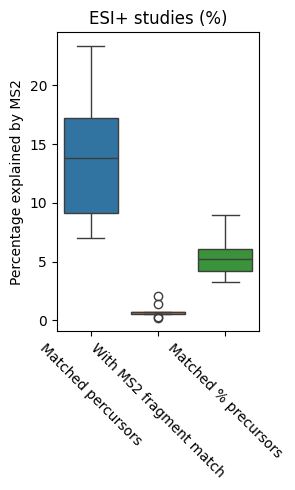

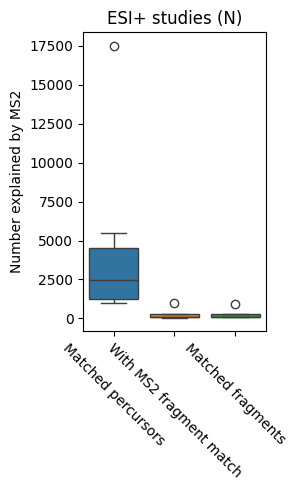

In [21]:
# per study stats, MS2, pos

perc_precursors, perc_precursors_has_ms2_fragment = [], []
ratios = []
for study in pos_summary:
    # have precursors: the features matched by MoNA precursors
    # precursor_features_w_ms2: the features matched by MoNA precursors, whose fragments also matched by MS2 peaks
    # num_features: total featurs in full feature table
    perc_precursors.append(
        100*study['have_precursors']/study['num_features'])
    perc_precursors_has_ms2_fragment.append(
        100* len(study['precursor_features_w_ms2'])/study['num_features'])
    ratios.append(
        100*len(study['precursor_features_w_ms2'])/study['have_precursors']
    )

_d = {
    'Matched percursors': perc_precursors,
    'With MS2 fragment match': perc_precursors_has_ms2_fragment,
    'Matched % precursors': ratios
}

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.boxplot(data=_d)
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("Percentage explained by MS2")
ax.set_title("ESI+ studies (%)")
plt.tight_layout()
plt.savefig('figs/tof/Fig1b_perc_explained_MS2_pos_ions.pdf')

# plot with raw numbers
_num_M0_features_w_percursors_w_ms2 = [len(study['precursor_features_w_ms2']) for study in pos_summary]
_num_frag_features_w_percursors_w_ms2_ = [
    len(study['fragment_features']) for study in pos_summary
]

_d = {
    'Matched percursors': [study['have_precursors'] for study in pos_summary],
    'With MS2 fragment match': _num_M0_features_w_percursors_w_ms2,
    'Matched fragments': _num_frag_features_w_percursors_w_ms2_,
}

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.boxplot(data=_d)
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("Number explained by MS2")
ax.set_title("ESI+ studies (N)")
plt.tight_layout()
plt.savefig('figs/tof/Fig1b_num_explained_MS2_pos_ions.pdf')


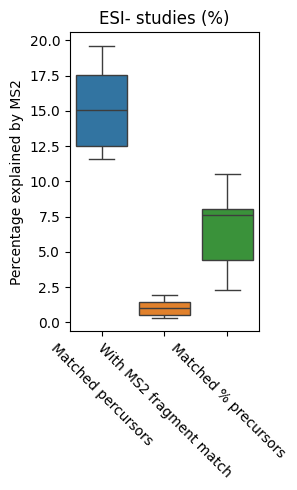

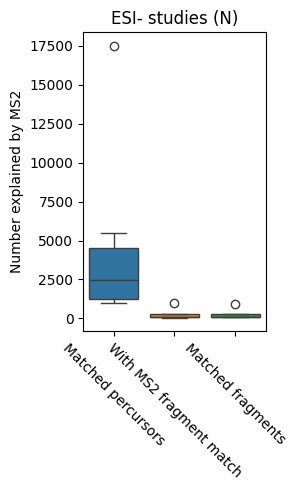

In [22]:
# per study stats, MS2, neg

perc_precursors, perc_precursors_has_ms2_fragment = [], []
ratios = []
for study in neg_summary:
    # have precursors: the features matched by MoNA precursors
    # precursor_features_w_ms2: the features matched by MoNA precursors, whose fragments also matched by MS2 peaks
    # num_features: total featurs in full feature table
    perc_precursors.append(
        100*study['have_precursors']/study['num_features'])
    perc_precursors_has_ms2_fragment.append(
        100* len(study['precursor_features_w_ms2'])/study['num_features'])
    ratios.append(
        100*len(study['precursor_features_w_ms2'])/study['have_precursors']
    )

_d = {
    'Matched percursors': perc_precursors,
    'With MS2 fragment match': perc_precursors_has_ms2_fragment,
    'Matched % precursors': ratios
}

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.boxplot(data=_d)
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("Percentage explained by MS2")
ax.set_title("ESI- studies (%)")
plt.tight_layout()
plt.savefig('figs/tof/Fig1b_perc_explained_MS2_neg_ions.pdf')


# plot with raw numbers
_num_M0_features_w_percursors_w_ms2 = [len(study['precursor_features_w_ms2']) for study in pos_summary]
_num_frag_features_w_percursors_w_ms2_ = [
    len(study['fragment_features']) for study in pos_summary
]

_d = {
    'Matched percursors': [study['have_precursors'] for study in pos_summary],
    'With MS2 fragment match': _num_M0_features_w_percursors_w_ms2,
    'Matched fragments': _num_frag_features_w_percursors_w_ms2_,
}

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.boxplot(data=_d)
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("Number explained by MS2")
ax.set_title("ESI- studies (N)")
plt.tight_layout()
plt.savefig('figs/tof/Fig1b_num_explained_MS2_neg_ions.pdf')

## Number of khipus and features explained by freq fragments

This is not completely in feature space, but "event" space, to have efficient computing.

by numbers, by %

per fragment, and cumulative

Since we predifined the freq delta values, we'll use values rounded to 0.01 for stats.


In [23]:
# get counts per fragment, and RT shift
posDeltas = []
for study in pos_summary:
    # get all (frag mass string, RT shift)
    posDeltas += [(str(round(x[0], 2)), x[2]) for x in study['freq_delta_values_used']]
    
massstrs = [x[0] for x in posDeltas]
set_massstrs = set(massstrs)
len(massstrs), len(set_massstrs)

(3048, 24)

**A few values need to be combined to x[0]**:

'2.01', '2.02'
'14.01', '14.02'
'15.99', '16.0', 
'26.01', '26.02', 

In [24]:
delta_counts = [(massstrs.count(x),x) for x in set_massstrs]
delta_counts.sort(reverse=True)
delta_counts

[(242, '18.01'),
 (236, '28.03'),
 (188, '46.01'),
 (175, '12.0'),
 (164, '2.02'),
 (146, '14.02'),
 (145, '42.05'),
 (143, '56.06'),
 (141, '30.01'),
 (138, '16.03'),
 (135, '44.03'),
 (134, '39.99'),
 (131, '27.99'),
 (130, '24.0'),
 (125, '9.98'),
 (107, '16.0'),
 (100, '26.02'),
 (100, '2.01'),
 (99, '14.01'),
 (76, '15.99'),
 (67, '26.01'),
 (60, '22.98'),
 (37, '32.03'),
 (29, '17.03')]

In [26]:
# manual fix of wrong splits
delta_counts = sorted([(242, '18.01'),
 (236, '28.03'),
 (188, '46.01'),
 (175, '12.0'),
 (164+100, '2.02'),
 (146+99, '14.02'),
 (145, '42.05'),
 (143, '56.06'),
 (141, '30.01'),
 (138, '16.03'),
 (135, '44.03'),
 (134, '39.99'),
 (131, '27.99'),
 (130, '24.0'),
 (125, '9.98'),
 (107+76, '16.0'),
 (100+67, '26.02'),
#  (100, '2.01'),
#  (99, '14.01'),
#  (76, '15.99'),
#  (67, '26.01'),
 (60, '22.98'),
 (37, '32.03'),
 (29, '17.03')
 ], reverse=True)

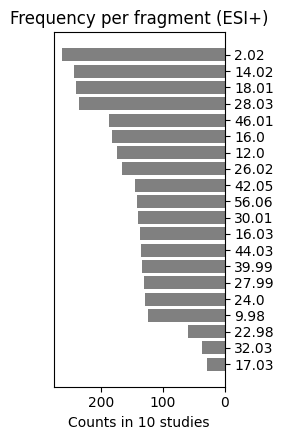

In [27]:
# Do barplot for pos

xlabels = [x[1] for x in delta_counts]
y = [x[0] for x in delta_counts]
x = range(len(y))

fig, ax = plt.subplots(figsize=(2.5, 4.5))
hbars = ax.barh(x, y, color='grey')
ax.set_yticks(x, labels=xlabels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.invert_xaxis()
ax.yaxis.tick_right() # will add annotation to delta mass values to right
ax.set_xlabel('Counts in 10 studies')
ax.set_title('Frequency per fragment (ESI+)')
plt.tight_layout()
plt.savefig("figs/tof/Fig2a_fragment_counts_pos_ions.pdf")

In [28]:
# helper to map the merged mz delta back
rt_helper = {
    '2.01': '2.02',
    '14.01': '14.02',
    '15.99': '16.0',
    '26.01': '26.02'
}

rt_dict = {}
for x in delta_counts:
    rt_dict[x[1]] = []
    
for x in posDeltas:
    if x[0] in rt_dict:
        rt_dict[x[0]].append(x[1])
    else:
        rt_dict[rt_helper[x[0]]].append(x[1])

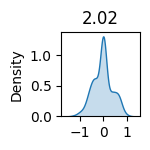

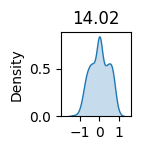

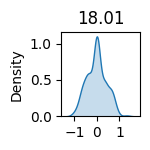

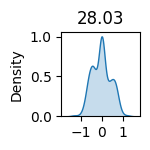

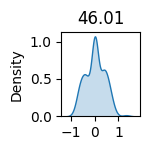

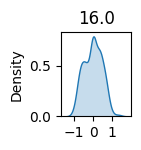

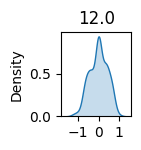

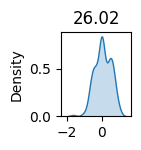

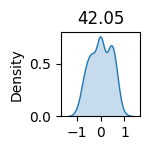

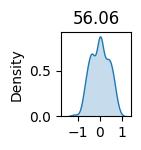

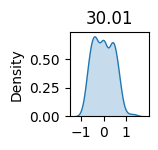

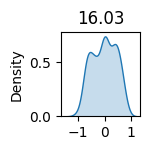

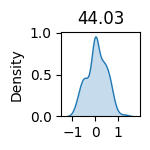

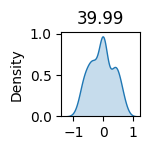

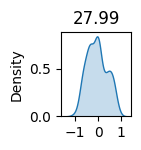

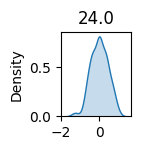

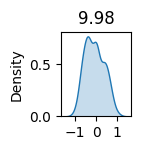

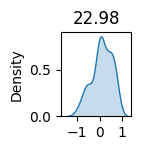

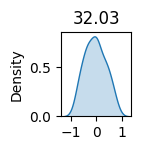

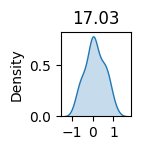

In [29]:
# plot RT shift for common deltas (rounded to 2 digits after decimal), pos
# Need to fix the extra 3 values
for k,v in rt_dict.items():
    plt.figure(figsize=(1.6,1.6))
    sns.kdeplot(data=v, fill=True)
    plt.title(k)
    plt.tight_layout()
    plt.savefig("figs/tof/rt_distr_pos/distribution_p_" + k + ".pdf")

**Note**

The shoulder shapes suggest a number of the cpds are not co-eluted.

Only pos delta mz values were used in previous steps. 
Why don't larger m/z values translate into larger RT? 
Types of columns matter?


median:  1.9321417214527115 0.4789523409088984
median:  30.5 77.0


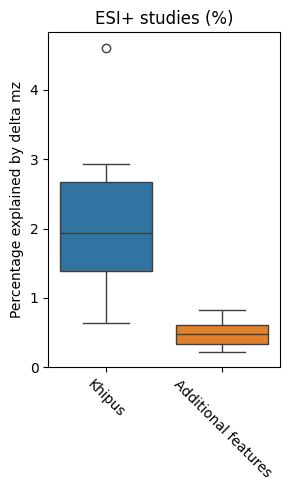

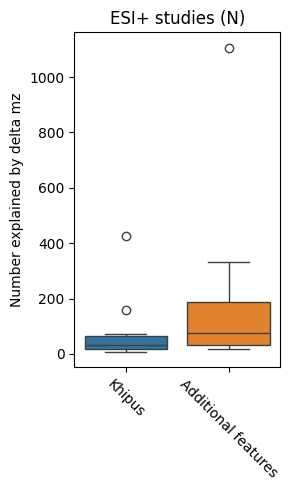

In [39]:
# per study stats, 
# additional khipu perc explained
# additional feature perc explained

perc_khipu_explaiend, perc_additional_features_explained = [], []
for study in pos_summary:
    perc_khipu_explaiend.append(
        100*study['mzdelta_explained_khipus']/study['num_khipus'])
    perc_additional_features_explained.append(
        100*study['mzdelta_explained_features']/study['num_features'])

_d = {
    'Khipus': perc_khipu_explaiend,
    'Additional features': perc_additional_features_explained,
}
# print median
print("median: ", np.median(_d['Khipus']), np.median(_d['Additional features']))

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.boxplot(data=_d)
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("Percentage explained by delta mz")
ax.set_title("ESI+ studies (%)")
plt.tight_layout()
plt.savefig('figs/tof/Fig2d_perc_explained_fragments_pos_ions.pdf')

# plot with raw numbers
_khipu_explaiend = [study['mzdelta_explained_khipus'] for study in pos_summary]
_additional_features_explained = [
    study['mzdelta_explained_features'] for study in pos_summary
]
_d = {
    'Khipus': _khipu_explaiend,
    'Additional features': _additional_features_explained,
}
# print median
print("median: ", np.median(_d['Khipus']), np.median(_d['Additional features']))

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.boxplot(data=_d)
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("Number explained by delta mz")
ax.set_title("ESI+ studies (N)")
plt.tight_layout()
plt.savefig('figs/tof/Fig2d_num_explained_fragments_pos_ions.pdf')



### Do neg ion for delta mz



In [31]:
# get counts per fragment, and RT shift
negDeltas = []
for study in neg_summary:
    # get all (frag mass string, RT shift)
    negDeltas += [(str(round(x[0], 2)), x[2]) for x in study['freq_delta_values_used']]
    
massstrs = [x[0] for x in negDeltas]
set_massstrs = set(massstrs)
print(len(massstrs), len(set_massstrs))

1748 24


**A few values need to be combined to x[0]**:

'2.01', '2.02'
'14.01', '14.02', 
'26.01', '26.02'
'46.0', '46.01'

In [32]:
delta_counts = [(massstrs.count(x),x) for x in set_massstrs]
delta_counts.sort(reverse=True)
delta_counts

[(176, '18.01'),
 (130, '60.02'),
 (115, '44.03'),
 (111, '74.04'),
 (107, '24.0'),
 (106, '2.02'),
 (90, '15.99'),
 (80, '10.03'),
 (74, '2.01'),
 (73, '14.02'),
 (68, '43.99'),
 (67, '1.01'),
 (60, '26.02'),
 (58, '129.96'),
 (57, '46.01'),
 (53, '61.97'),
 (51, '46.0'),
 (49, '6.02'),
 (49, '1.0'),
 (44, '67.99'),
 (44, '26.01'),
 (34, '135.97'),
 (31, '14.01'),
 (21, '82.0')]

In [34]:
# manual fix of wrong splits
delta_counts = sorted([(176, '18.01'),
 (130, '60.02'),
 (115, '44.03'),
 (111, '74.04'),
 (107, '24.0'),
 (106, '2.02'),
 (90, '15.99'),
 (80, '10.03'),
#  (74, '2.01'),
 (73, '14.02'),
 (68, '43.99'),
 (67, '1.01'),
 (60, '26.02'),
 (58, '129.96'),
 (57, '46.01'),
 (53, '61.97'),
#  (51, '46.0'),
 (49, '6.02'),
 (49, '1.0'),
 (44, '67.99'),
#  (44, '26.01'),
 (34, '135.97'),
#  (31, '14.01'),
 (21, '82.0')
 ], reverse=True)

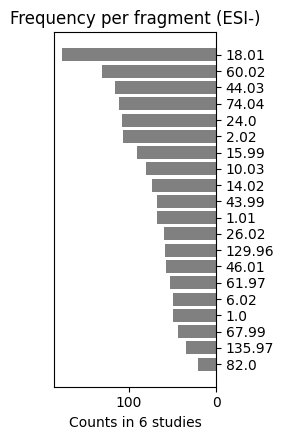

In [35]:
# Do barplot for neg

xlabels = [x[1] for x in delta_counts]
y = [x[0] for x in delta_counts]
x = range(len(y))

fig, ax = plt.subplots(figsize=(2.5, 4.5))
hbars = ax.barh(x, y, color='grey')
ax.set_yticks(x, labels=xlabels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.invert_xaxis()
ax.yaxis.tick_right() # will add annotation to delta mass values to right
ax.set_xlabel('Counts in 6 studies')
ax.set_title('Frequency per fragment (ESI-)')
plt.tight_layout()
plt.savefig("figs/tof/Fig2b_fragment_counts_neg_ions.pdf")

In [36]:
# helper to map the merged mz delta back
rt_helper = {
    '2.01': '2.02',
    '14.01': '14.02', 
    '26.01': '26.02',
    '46.0': '46.01',
}

rt_dict = {}
for x in delta_counts:
    rt_dict[x[1]] = []
    
for x in negDeltas:
    if x[0] in rt_dict:
        rt_dict[x[0]].append(x[1])
    else:
        rt_dict[rt_helper[x[0]]].append(x[1])

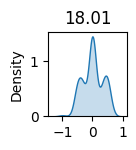

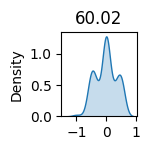

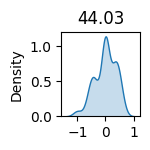

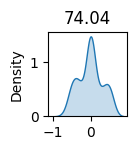

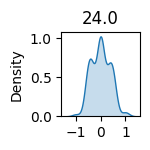

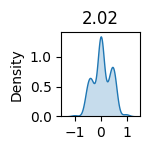

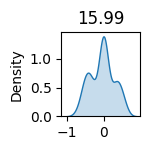

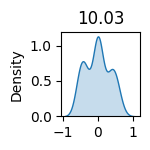

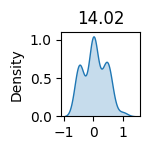

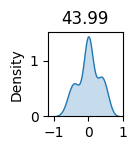

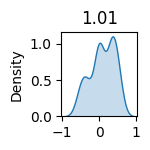

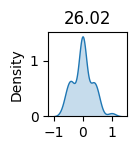

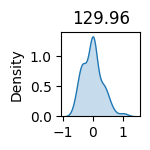

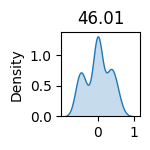

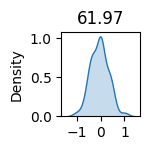

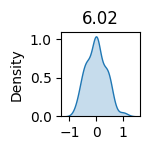

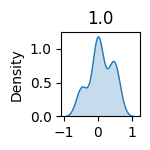

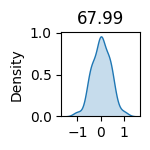

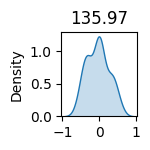

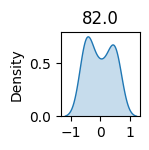

In [37]:
# plot RT shift for common deltas (rounded to 2 digits after decimal), neg
# Need to fix the extra 3 values
for k,v in rt_dict.items():
    plt.figure(figsize=(1.6,1.6))
    sns.kdeplot(data=v, fill=True)
    plt.title(k)
    plt.tight_layout()
    plt.savefig("figs/tof/rt_distr_neg/distribution_n_" + k + ".pdf")

median:  3.5109051563174094 0.701108459137411
median:  70.5 141.5


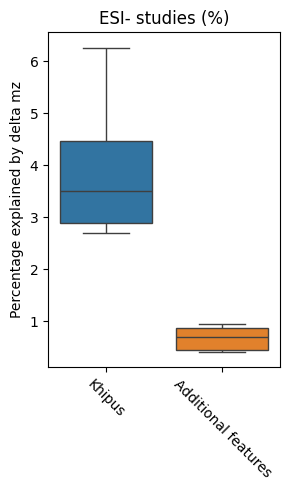

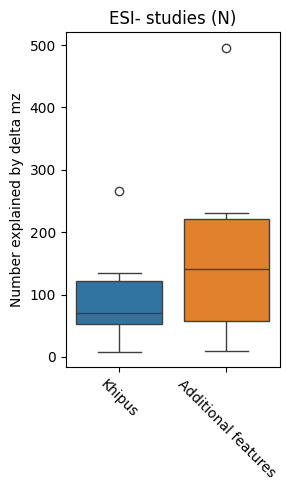

In [41]:
# per study stats, 
# additional khipu perc explained
# additional feature perc explained

perc_khipu_explaiend, perc_additional_features_explained = [], []
for study in neg_summary:
    perc_khipu_explaiend.append(
        100*study['mzdelta_explained_khipus']/study['num_khipus'])
    perc_additional_features_explained.append(
        100*study['mzdelta_explained_features']/study['num_features'])

_d = {
    'Khipus': perc_khipu_explaiend,
    'Additional features': perc_additional_features_explained,
}
# print median
print("median: ", np.median(_d['Khipus']), np.median(_d['Additional features']))

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.boxplot(data=_d)
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("Percentage explained by delta mz")
ax.set_title("ESI- studies (%)")
plt.tight_layout()
plt.savefig('figs/tof/Fig2d_per_explained_fragments_neg_ions.pdf')

# plot with raw numbers
_khipu_explaiend = [study['mzdelta_explained_khipus'] for study in neg_summary]
_additional_features_explained = [
    study['mzdelta_explained_features'] for study in neg_summary
]
_d = {
    'Khipus': _khipu_explaiend,
    'Additional features': _additional_features_explained,
}
# print median
print("median: ", np.median(_d['Khipus']), np.median(_d['Additional features']))

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.boxplot(data=_d)
ax.tick_params(axis='x', rotation=315)
ax.set_ylabel("Number explained by delta mz")
ax.set_title("ESI- studies (N)")
plt.tight_layout()
plt.savefig('figs/tof/Fig2d_num_explained_fragments_neg_ions.pdf')

# Conclusion

This notebook plots Figures 1-2, how MS2 and frequent delta m/z explain the 16 ToF datasets.